In [1]:
from scipy import io
import pandas as pd
import umap # First time you run this enter pip install umap-learn in your Anaconda Prompt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

# Obtaining data and data cleaning

In [2]:
def mtx_to_df (mtf, columns_file, rows_file):
    """Takes and mtf file path, a column file path and a row file path of an mtf file and returns a pandas dataframe"""
    import pandas as pd
    cols = []
    rows = []
    data = io.mmread(mtf)
    with open(columns_file) as file:
        for line in file:
            cols.append(line.rstrip())
    
    with open(rows_file) as file:
        for line in file:
            rows.append(line.rstrip().split('\t')[0])
    arr = data.toarray()
    pd.DataFrame(arr, index = rows, columns = cols).to_csv('norm_counts_data.csv')

In [3]:
norm = 'E-GEOD-100911.aggregated_filtered_normalised_counts.mtx'
c = 'E-GEOD-100911.aggregated_filtered_normalised_counts.mtx_cols'
r = 'E-GEOD-100911.aggregated_filtered_normalised_counts.mtx_rows'

#mtx_to_df(norm,c,r)
norm_counts = pd.read_csv('norm_counts_data.csv')

In [4]:
# This was run to convert the gene transcript IDs to KEGG IDs, since this process took so long
# the result was saved to a csv (geneID.csv) file and this code is not needed anymore. 

# from Bio import Entrez
# import time
# import csv

# Entrez.email = "mdpouls1@gmail.com"
# geneIDs = []
# rowsTest = rows[15000:]
# i = 0
# while i < len(rowsTest):
#     for t in range(3):
#         if i < len(rowsTest):
#             handle = Entrez.esearch(db="gene", term=rowsTest[i])
#             record = Entrez.read(handle)
#             if len(record['IdList']) == 1:
#                 geneIDs.append(record['IdList'][0])
#             elif len(record['IdList']) > 1:
#                 geneIDs.append('multiple')
#             else:
#                 geneIDs.append('NaN')
#             handle.close()
#             i += 1
#     time.sleep(1)

# with open('geneID.csv', 'a') as f:
#     for gene in geneIDs:
#         f.write('{},'.format(gene))


In [5]:
def getAnnotations(uniprotData):
    """Takes the uniprotData file and creates a csv file with the gene ontologys (biological process) for each gene.
    uniprot chart must include a gene ontology (biological process) column and either a Ids column or Gene names column. 
    The created csv has the gene ontologies as  columns and genes as rows with a 0 if the gene does not contain the GO term 
    and a 1 if it does"""
    
    #read the csv into a dataframe
    annotationData = pd.read_table(uniprotData)
    
    #get a list of all the used GO terms in the dataset
    GO = []
    go_dict = {}
    for line in annotationData['Gene ontology (biological process)'].str.split(';'):
        if type(line) == list:
            for item in line:
                GO.append(item.strip())

    #create a dictionary with an empty list for each GO term
    for term in GO:
        if term not in go_dict:
            go_dict[term] = []

    #check each gene 
    for line in annotationData['Gene ontology (biological process)'].str.split(';'):
        item_dict = {}
        if type(line) == list:
            for item in line:
                item_dict[item.strip()] = True
            for k,v in go_dict.items():
                if k in item_dict:
                    v.append(1)
                else:
                    v.append(0)


    go_df = pd.DataFrame.from_dict(go_dict)
    
    if "Ids" in annotationData.columns:
        go_df['geneId'] = annotationData['Ids']
        go_df = go_df.set_index('geneId')
    
    if 'Gene names' in annotationData.columns:
        go_df['geneName'] = annotationData['Gene names']
        go_df = go_df.drop_duplicates(subset = 'geneName')
        go_df = go_df.set_index('geneName')

    go_df.to_csv('goData.csv')
    return(go_df)
    


In [6]:
def getCellGOTerms(norm_counts,GO_dataframe, filepathName):
    """Takes the normalized counts as a dataframe of normalized counts with cell IDs as the columns and gene names as the rows.
    The normalized counts dataframe must have the column with the gene IDs named '1'. the GO_dataframe parameter is the output 
    from the getAnnotations function. The filepathName is the name of the file you want the csv to be written to
    
    Writes a csv of the relative amounts of a gene ontology term a cell has based off the differentially expressed genes. The
    csv has the GO term as colums and the cell ID as rows."""
    
    norm_counts_id = norm_counts.set_index("1")
    srr_dict = norm_counts_id.to_dict()


    #Convert the go_df datafram into a dictionary of lists for the indices, columns, and data
    gene_dict = GO_dataframe.to_dict('split')

    #create a dictionary with the gene ID as the key and a list of the gene ontologies for that gene
    geneID_dict = {}
    for ind, data in gene_dict.items():
        geneID_dict[ind] = data


    ids = gene_dict['index']
    data = gene_dict['data']

    geneID_dict = {}
    for i in range(len(ids)):
        geneID_dict[ids[i]] = data[i]

    srr_genes_dict_values = {}
    for srr,genes in srr_dict.items():
        genes_GO = np.zeros((len(GO_dataframe.columns),), dtype=int)
        for gene,value in genes.items():
            if value > 0:
                if gene in geneID_dict:
                    genes_GO = np.add(genes_GO,np.multiply(value, np.array(geneID_dict[gene])))
        srr_genes_dict_values[srr] = genes_GO

    #convert to a dataframe
    cols = GO_dataframe.columns
    gene_annotation_values_df = pd.DataFrame.from_dict(srr_genes_dict_values, orient='index', columns = cols)
    #write data to a csv file
    gene_annotation_values_df.to_csv('{}.csv'.format(filepathName))

In [7]:
# gagnonData_path = "uniprot_gagnon.tab.gz"
# toyData_path = "uniprotData.tab"

# testis = getAnnotations(gagnonData_path)
# kidney = getAnnotations(toyData_path)

# getCellGOTerms(norm_counts,testis,'GeneAnnotation_gagnon')
# getCellGOTerms(norm_counts,kidney,'GeneAnnotation')

In [8]:
norm_counts = norm_counts.set_index('Unnamed: 0')
norm_transpose = norm_counts.transpose()

# UMAP Reduction:

See the UMAP Documentation page for details. The module import cell at the top of this notebook has instructions for downloading the scikit learn plug-in for UMAP.

NOTE This is a first pass - I'm not super sure it is ready to go. Next steps

1 We need to cluster the data and assign tags to the data points

2 Add a third dimension to the UMAP reduction

3 Plot data in altair to allow interaction

4 Add interaction steps, tags, whatever else we're doing!


In [9]:
norm_counts_temp = norm_counts
norm_counts_temp = norm_counts_temp.drop(['geneIDs'],axis=1).transpose()
norm_vals = norm_counts_temp.values

In [10]:
norm_vals_scaled = StandardScaler().fit_transform(norm_vals)

In [11]:
UMAP_reducer = umap.UMAP()
reduced_genes = UMAP_reducer.fit_transform(norm_vals_scaled)
print('Done')

Done


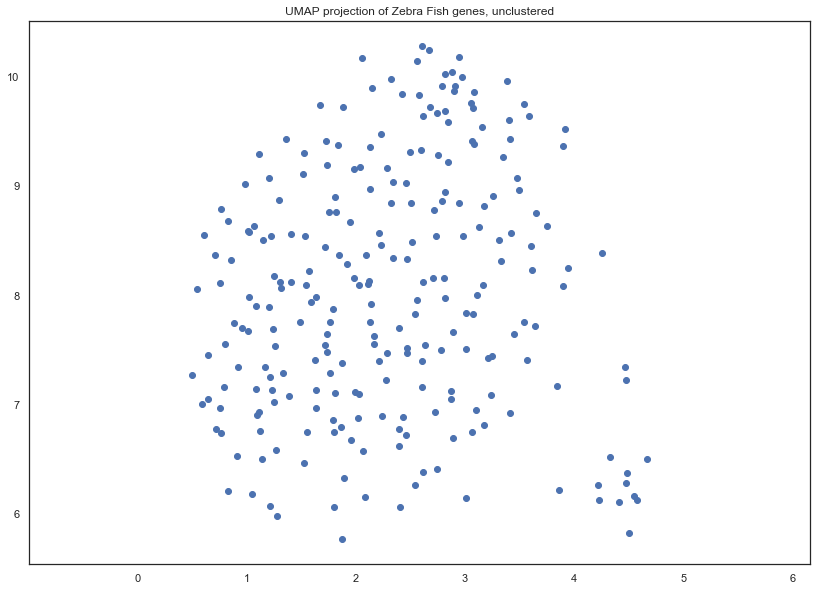

In [12]:
plt.scatter(reduced_genes[:,0],reduced_genes[:,1])
plt.gca().set_aspect('equal','datalim')
plt.title('UMAP projection of Zebra Fish genes, unclustered')
plt.show;

In [13]:
X = norm_vals_scaled
# PCA
pca_mod = PCA(n_components = 7)
data_pca = pca_mod.fit_transform(X)
PCs =pca_mod.components_
PCs.shape

(7, 17432)

In [14]:
UMAP_mod = umap.UMAP(n_neighbors = 7, min_dist = 0.2, n_components = 3).fit_transform(X)

In [15]:
# K means
y_pred = KMeans(n_clusters=7, max_iter=5).fit_predict(X)

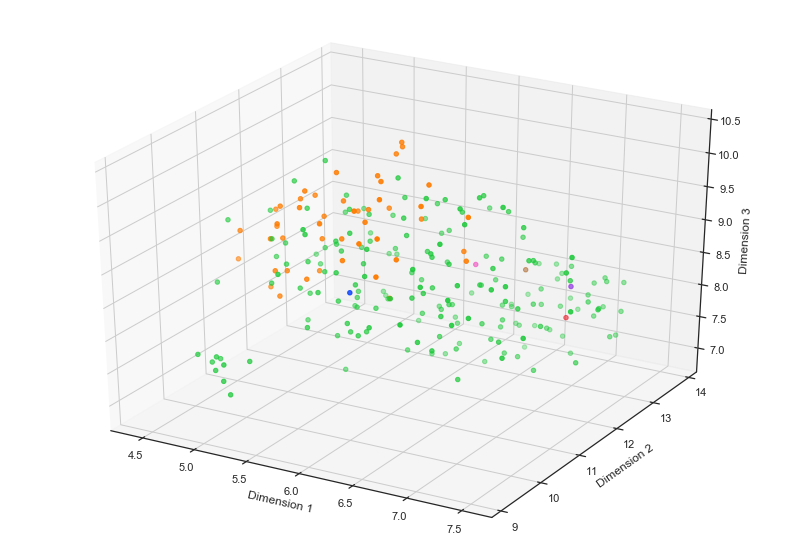

In [16]:
# colors
from matplotlib.colors import ListedColormap
colors = ListedColormap(sns.color_palette('bright', 7).as_hex())
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(UMAP_mod[:, 0], UMAP_mod[:, 1],zs= UMAP_mod[:, 2], c=y_pred, cmap= colors, s=20)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.show()

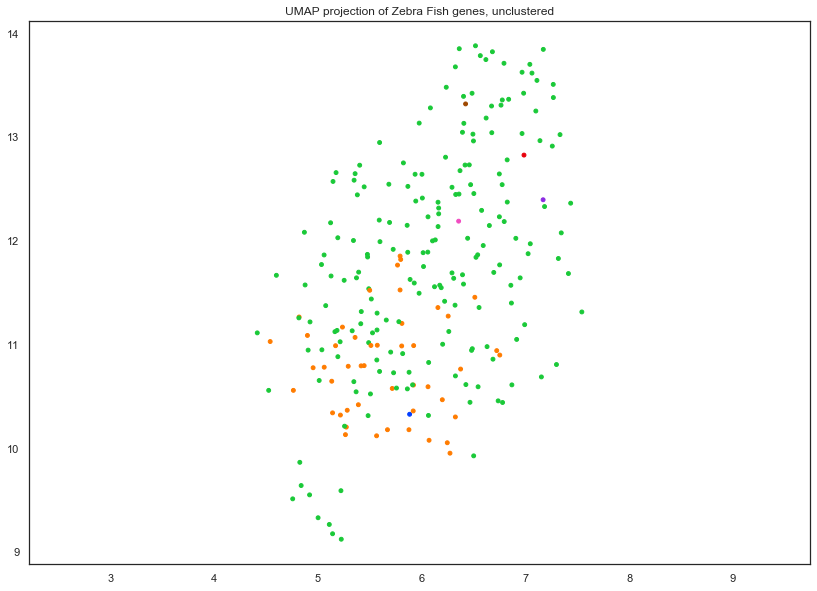

In [17]:
plt.scatter(UMAP_mod[:,0],UMAP_mod[:,1], c = y_pred, cmap = colors, s=15)
plt.gca().set_aspect('equal','datalim')
plt.title('UMAP projection of Zebra Fish genes, unclustered')
plt.show;

## Get top gene ontologies:  
**The** top gene ontologies are defined in this project as those that have the largest (absolute) parameter value in the final equation for the principal direction. 

In [18]:
annotation = pd.read_csv('GeneAnnotation.csv')
annot_vals = annotation.values

annot_scaled = StandardScaler().fit_transform(annot_vals)


# PCA on gene ontologies: Use this to figure out het
pca_mod = PCA(n_components = 1) 
data_pca = pca_mod.fit_transform(annot_scaled)
PCs =pca_mod.components_

In [19]:
PCs_df = pd.DataFrame(PCs)
PCs_df = PCs_df.transpose()
PCs_df[1] = abs(PCs_df[0])
topGo = PCs_df[1].sort_values(ascending = False).head(100).index #List of the index of the top gene ontologies

In [20]:
top_annotations = annotation.iloc[:,topGo] # Grab the top 100 annotations
labels=top_annotations.columns
min_max_scaler = preprocessing.MinMaxScaler()
top_annotations[:] = min_max_scaler.fit_transform(top_annotations.values) #Scale the data to be in range [0,1]
top_annotations.columns = np.arange(0,len(top_annotations.columns))
top_annotations.head() #df with only the top 100 most important group ontologies listed for each cell

<ipython-input-20-d612124b8400>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_annotations[:] = min_max_scaler.fit_transform(top_annotations.values) #Scale the data to be in range [0,1]
C:\Users\Matt\anaconda3\lib\site-packages\pandas\core\frame.py:2945: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer(key, value)
C:\Users\Matt\anaconda3\lib\site-packages\pandas\core\frame.py:2930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
SRR5810686,0.315942,0.344355,0.244595,0.207821,0.244595,0.274292,0.244372,0.288163,0.195930,0.231081,...,0.238645,0.009517,0.202107,0.000192,0.085822,0.231608,0.105019,0.329226,0.374308,0.186222
SRR5810687,0.205438,0.269238,0.205864,0.174865,0.191223,0.203596,0.197559,0.413916,0.164953,0.221265,...,0.196869,0.007226,0.086155,0.071441,0.064887,0.123865,0.070676,0.109447,0.410379,0.181925
SRR5810688,0.233348,0.437610,0.245445,0.155158,0.245361,0.252144,0.179864,0.381273,0.140107,0.263221,...,0.241517,0.303549,0.079447,0.714754,0.138971,0.191650,0.069592,0.157058,0.392570,0.117056
SRR5810689,0.326229,0.613761,0.395484,0.226187,0.395484,0.494825,0.296611,0.521143,0.207672,0.287414,...,0.289613,0.012471,0.160766,0.000000,0.082095,0.352840,0.132533,0.216812,0.566577,0.174929
SRR5810690,0.449048,0.453440,0.444168,0.336514,0.444090,0.479056,0.344524,0.748712,0.310655,0.266631,...,0.315444,0.001652,0.159799,0.058521,0.039245,0.386445,0.137788,0.349325,0.587211,0.254263


## Visualization:
**Overview**
 - The 'base' plot is the 2-D UMAP plot plotted using Altair. 
 - A user can then select a region-of-interest to create the breakout histogram plots of predominate gene ontology

In [21]:
import altair as alt

### Create visualization dataframe:  
**Overview** 

In [22]:
# Create 'base' dataframe:
column_names = ["UMAP x","UMAP y"]
vis_data = pd.DataFrame(reduced_genes, columns = column_names)
vis_data["Clusters"] = y_pred # Add clusters:
vis_data['IDs'] = top_annotations.index.values
# vis_data[top_annotations.columns] = top_annotations.values # Bring in the 'top annotations'

# vis_data.head()
# vis_data.plot.bar(y=1)
vis_data

,UMAP x,UMAP y,Clusters,IDs
0,4.545163,6.155877,2,SRR5810686
1,4.578258,6.119338,2,SRR5810687
2,3.238501,7.088530,2,SRR5810688
3,4.472604,7.225544,2,SRR5810689
4,1.280073,5.981124,2,SRR5810690
...,...,...,...,...
241,1.571650,8.221041,2,SRR5810927
242,2.474612,7.468272,2,SRR5810928
243,2.744480,9.666321,2,SRR5810929
244,2.679228,9.722860,2,SRR5810930


In [23]:
## CHOOSE NUMBER OF ONTOLOGIES TO BE IN CHART!!!
num_ontologies = 20

# Ceate a 'long' chart of the form [CellID | Annotation type | Annotation Value] (and probably UMAPs...)
annotation_play = top_annotations
annotation_play['ids'] = annotation_play.index
vals = np.arange(0,num_ontologies)
annotation_play = pd.melt(top_annotations, id_vars=['ids'], value_vars=vals, var_name = 'ontology')
annotation_play['UMAP x'] = ''
annotation_play['UMAP y'] = ''
annotation_play['Cluster'] = ''

## ADD THE UMAP LOCATIONS AND CLUSTER ID FOR EACH INSTANCE OF EACH CELL:
# PS: Kinda hacked this one together.... so it takes a quick sec to run
cnt = 1
for i in range(len(annotation_play)):
    for j in range(len(vis_data)):
        if annotation_play.loc[i, 'ids'] == vis_data.loc[j,'IDs']:
            annotation_play.loc[i, 'UMAP x'] = float(vis_data.loc[j,'UMAP x'])
            annotation_play.loc[i, 'UMAP y'] = float(vis_data.loc[j,'UMAP y'])
            annotation_play.loc[i, 'Cluster'] = int(vis_data.loc[j,'Clusters'])
#             print(len(annotation_play) - cnt)
            cnt += 1

annotation_play

<ipython-input-23-4d83481a493e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  annotation_play['ids'] = annotation_play.index


,ids,ontology,value,UMAP x,UMAP y,Cluster
0,SRR5810686,0,0.315942,4.54516,6.15588,2
1,SRR5810687,0,0.205438,4.57826,6.11934,2
2,SRR5810688,0,0.233348,3.2385,7.08853,2
3,SRR5810689,0,0.326229,4.4726,7.22554,2
4,SRR5810690,0,0.449048,1.28007,5.98112,2
...,...,...,...,...,...,...
4915,SRR5810927,19,0.040676,1.57165,8.22104,2
4916,SRR5810928,19,0.000000,2.47461,7.46827,2
4917,SRR5810929,19,0.069548,2.74448,9.66632,2
4918,SRR5810930,19,0.172364,2.67923,9.72286,2


### Create 'master' plot  
**TODO** 
 - Add cluster colors
 - Add IDs when hovering?
 - Add ROI selection


### Create histogram plot of ontologies:
**Thoughts:**
 - Altair can plot more than the 'maxrows' limit, although it becomes very sluggish. They recommend to save the data locally as JSON and reference a path to it.

In [24]:
# Create labels dataframe:
labels.tolist()
df_labels = pd.DataFrame(labels.tolist(), columns=['labels'])
df_labels = df_labels.loc[:num_ontologies,:]
df_labels

,labels
0,"mRNA splicing, via spliceosome [GO:0000398]"
1,protein import into peroxisome membrane [GO:00...
2,retinal metabolic process [GO:0042574]
3,epithelial cell differentiation involved in ki...
4,epithelial cell differentiation [GO:0030855]
5,embryonic pectoral fin morphogenesis [GO:0035118]
6,regulation of cilium assembly [GO:1902017]
7,citrate metabolic process [GO:0006101]
8,epiboly [GO:0090504]
9,tumor necrosis factor-mediated signaling pathw...


### Display tool!
**This is where our interaction is!**

In [25]:
# Save data to a local JSON format:
data_JSON = alt.data_transformers.enable('json')
# Turn off max_rows limit -- this makes the visualization clunky
alt.data_transformers.disable_max_rows()

ROI = alt.selection_interval()
click = alt.selection_multi()

scatter_base = alt.Chart(annotation_play).mark_circle().encode(
    x='UMAP x',
    y='UMAP y',
    color = alt.Color('Cluster:N', scale=alt.Scale(scheme = 'set1'))
).properties(
    width = 500,
    height = 200
).add_selection(ROI, click)

br_sz = 20
hist_base = alt.Chart(annotation_play).mark_bar(size=br_sz).encode(
    x='ontology',
    y='mean(value):Q'
).properties(
    width = 500,
    height = 200
)

hist_roi = alt.Chart(annotation_play).mark_bar(size=br_sz, opacity=0.5).encode(
    alt.X('ontology'),
    alt.Y('mean(value):Q',
          scale=alt.Scale(domain=(0,1))),
    color=alt.value('red')
).properties(
    width = 500,
    height = 200
).transform_filter(
    ROI | click
)

# hist_labels = alt.Chart(df_labels).mark_text(align='center', baseline='bottom',
#                                  dy=35, fontSize=12
#                                  ).encode(
# y=alt.value(100),
# text='labels:N')


scatter_base & (hist_base + hist_roi)
# hist_labels

alt.VConcatChart(...)

## Main Dataset

 This is unpublished data from the Gagnon lab from the [cell ranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger) pipeline. I loaded the files, cleaned the data and created a (large) csv file to load in.  As discussed in peer feedback, the unpublished data will be shared will a Google Drive link below.

In [26]:
#testis1_data_ = io.mmread('matrix.mtx.gz')
#data_arr = testis1_data_.toarray()
#data_col = pd.read_csv('barcodes.tsv.gz', compression = 'gzip', header=None, sep = '\t')
#data_row = pd.read_csv('features.tsv.gz', compression = 'gzip', header=None,sep = '\t')
#data_rows = data_row[1]
#data_cols = []
#for b in data_col[0]:
#    data_cols.append(b)
#data_counts = pd.DataFrame(data_arr, index = data_rows, columns = data_cols)
#data_counts.to_csv('data_counts_data.csv')

### Here is the link to the csv file I generated with the code above: [t1_counts_data.csv](https://drive.google.com/file/d/1aIR4w9TIOnMxziE5aQVjIMAWvqEY6Mvq/view?usp=sharing)

In [28]:
# The csv file above needs to be downloaded to load this cell
# It is a large dataset, so it may take a while to load
data_counts = pd.read_csv('t1_counts_data.csv', header = 0)
data_counts.set_index('1', inplace = True)
data_counts.shape

(32520, 8627)

# Quality control of the cells

In [29]:
# percentage of mitochondrial rna
mitochondrial = data_counts[data_counts.index.str.contains('mt-') > 0].sum(0)
total = data_counts.sum(0)
mito_percentage = (mitochondrial/total) * 100
filter_out = mito_percentage[mito_percentage < 5].index
data_counts = data_counts[filter_out] # filter out anything higher than 5%

# filter by counts of genes (a very large amount of transcribed genes implies more than one cell is captured)
gene_counts = []
for i,cell in enumerate(data_counts.columns):
    counter = 0
    for row in data_counts.iloc[:,i]:
        if row > 0:
            counter += 1
    gene_counts.append(counter)
count_mask = []
for count in gene_counts:
    if count > 200 & count < 2500:
        count_mask.append(gene_counts.index(count))
data_counts = data_counts.iloc[:,count_mask]
data_counts.shape



(32520, 8562)

In [30]:
indicies = np.arange(0,8627)
mask = np.ones((len(indicies),1))
for i in range(len(mask)):
    if indicies[i] not in count_mask:
        mask[i] = 0
        print('count')
    elif indicies[i] not in filter_out:
        mask[i] = 0
        print('indicies')
sum(mask==0)

indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
count
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
count
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
count
count
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indi

count
count
indicies
indicies
count
count
count
indicies
indicies
count
count
indicies
indicies
indicies
count
indicies
indicies
count
indicies
count
count
indicies
count
count
count
indicies
indicies
count
count
count
indicies
indicies
indicies
count
count
count
count
count
count
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
count
indicies
count
indicies
indicies
indicies
indicies
count
count
count
indicies
indicies
count
indicies
indicies
count
count
indicies
count
count
indicies
count
count
count
indicies
count
indicies
indicies
count
indicies
count
count
count
count
indicies
count
indicies
count
indicies
indicies
indicies
indicies
indicies
indicies
indicies
indicies
count
count
count
count
indicies
indicies
count
indicies
count
indicies
count
count
count
count
indicies
count
indicies
indicies
indicies
indicies
indicies
count
count
count
indicies
indicies
count
indicies
count
indicies
indicies
indicies
indicies
indicies
indicies
indicies
count
coun

indicies
count
count
count
count
count
count
count
count
indicies
count
count
count
indicies
count
indicies
indicies
count
count
count
indicies
count
count
count
indicies
indicies
count
count
count
count
indicies
count
indicies
count
indicies
count
indicies
count
indicies
indicies
count
indicies
count
count
count
indicies
count
indicies
count
indicies
indicies
count
indicies
indicies
indicies
count
count
count
indicies
count
indicies
count
indicies
indicies
indicies
count
count
indicies
count
indicies
count
indicies
indicies
indicies
indicies
count
count
count
count
indicies
indicies
indicies
indicies
indicies
count
indicies
count
count
count
indicies
count
count
indicies
indicies
count
count
indicies
count
count
indicies
count
count
count
count
count
count
indicies
count
indicies
count
count
count
count
count
count
indicies
indicies
count
count
count
count
count
count
count
count
count
indicies
indicies
count
indicies
count
count
count
count
count
count
indicies
count
count
count
coun

count
count
indicies
count
count
indicies
count
count
count
count
count
indicies
count
indicies
count
count
count
count
indicies
indicies
count
count
count
count
count
count
count
count
count
count
count
indicies
count
count
indicies
count
count
count
count
indicies
count
indicies
indicies
count
count
count
count
count
count
count
count
count
count
count
count
count
indicies
indicies
count
count
indicies
indicies
count
count
count
indicies
count
count
indicies
indicies
count
count
count
count
indicies
count
count
count
indicies
count
count
count
count
count
indicies
count
indicies
indicies
count
count
count
indicies
count
count
count
count
count
count
count
count
count
indicies
indicies
count
count
indicies
indicies
count
count
indicies
count
count
count
indicies
count
indicies
indicies
count
indicies
count
indicies
count
count
count
count
count
count
indicies
count
count
count
indicies
count
count
count
count
count
count
count
indicies
count
count
indicies
count
count
count
count
indi

count
count
count
count
count
count
count
count
count
indicies
indicies
count
indicies
count
count
count
count
count
count
count
count
count
indicies
count
count
count
indicies
indicies
indicies
count
count
count
count
count
count
count
count
count
count
count
indicies
count
count
count
count
indicies
indicies
count
indicies
indicies
count
count
count
count
count
indicies
count
indicies
count
indicies
count
count
count
indicies
count
count
count
count
count
count
count
count
count
count
count
indicies
count
count
count
count
count
count
count
count
count
count
count
count
count
indicies
count
count
count
count
indicies
indicies
count
indicies
count
count
count
count
count
count
count
indicies
count
indicies
indicies
count
count
count
count
count
count
count
count
indicies
count
count
count
count
count
count
indicies
count
count
count
count
count
count
indicies
indicies
indicies
count
count
indicies
indicies
count
count
count
count
count
count
count
count
count
count
count
count
count
i

count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
indicies
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
indicies
count
count
count
count
count
count
count
count
count
count
count
indicies
count
count
count
indicies
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
indicies
count
count
count
count
count
count
indicies
count
indicies
count
count
count
count
count
count
count
count
indicies
count
count
indicies
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
indicies
count
count
count
indicies
indicies
count
count
count
count
count
count
count
coun

indicies
count
count
count
count
count
count
count
count
indicies
count
count
count
indicies
indicies
count
count
indicies
count
count
count
count
count
indicies
count
count
count
count
count
count
count
count
count
count
count
count
count
indicies
count
count
count
count
indicies
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
indicies
count
count
count
count
count
count
count
indicies
count
count
count
count
count
indicies
count
indicies
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
indicies
count
count
count
count
count
count
count
count
count
count
count
count
count
indicies
indicies
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
count
indicies
count
count
count
count
count
count
count
count
count
count
count
indicies
count
count
count
count
count
count
count
count
c

array([8627])

In [31]:
# Define features (genes) and samples (cell_ids)
genes = data_counts.index.values
cell_ids = data_counts.columns

In [32]:
top_genes = pd.read_csv('top_genes.csv')
dc2 = data_counts.transpose()
dc2[top_genes['0'].drop_duplicates()].head()


FileNotFoundError: [Errno 2] File top_genes.csv does not exist: 'top_genes.csv'

### Apply the same UMAP pipeline as above with new data:

**Pipeline for finding neighbors:**
 - Set test and train datasets
 - Set a list of k's like [k for k in range(2,10)] or something like that
 - Build loops for k's that sets the k-nn classifier as knn_model, then use knn_model.fit for the data, set y_pred with     knn_model.predict(X_test) and use the metrics.accuracy_score(y_true=y_test, y_pred=y_pred) for scores for each k

In [33]:
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

In [34]:
norm_vals = data_counts.transpose().values
# norm_vals = dc2.values
norm_vals_scaled = StandardScaler().fit_transform(norm_vals)
print('Done')

Done


In [35]:
# Split data for development purposes:
X_train, X_test = train_test_split(norm_vals_scaled, test_size=0.75, random_state=1) #Reduce the number of cells for the clustering:
print('done')
# UMAP_train = umap.UMAP(n_neighbors = 7, min_dist = 0.2, n_components = 2).fit_transform(X_train)

done


## Optimizing the UMAP parameters:
**We** manually ran the two boxes below with varying parameters and visually assessed the results to identify our 'best' parameters for the UMAP reduction

In [36]:
'''UMAP_mod = umap.UMAP(n_neighbors = 13, min_dist = .5, n_components = 2).fit_transform(X_train)
print('done')'''

"UMAP_mod = umap.UMAP(n_neighbors = 13, min_dist = .5, n_components = 2).fit_transform(X_train)\nprint('done')"

In [37]:
'''plt.scatter(UMAP_mod[:,0],UMAP_mod[:,1])
plt.gca().set_aspect('equal','datalim')
plt.title('UMAP projection of Zebra Fish genes, unclustered')
plt.show;'''

"plt.scatter(UMAP_mod[:,0],UMAP_mod[:,1])\nplt.gca().set_aspect('equal','datalim')\nplt.title('UMAP projection of Zebra Fish genes, unclustered')\nplt.show;"

In [38]:
def np_to_csv(numpy_array, write_name):
    df_temp = pd.DataFrame(numpy_array)
    df_temp.to_csv(write_name)
    print('Successfully wrote array as ' + write_name)

## Optimize kmeans clustering!

In [39]:
'''n_rng = np.arange(3,9)
score = []
for n in n_rng:
    print('Working on: %d' % n)
    mdl = KMeans(n_clusters = 12, max_iter=10, random_state=1, ).fit(X_train)
    score.append(metrics.silhouette_score(x_train, mdl.labels_, metric='euclidean'))
print(n_rng)
print(score)'''

"n_rng = np.arange(3,9)\nscore = []\nfor n in n_rng:\n    print('Working on: %d' % n)\n    mdl = KMeans(n_clusters = 12, max_iter=10, random_state=1, ).fit(X_train)\n    score.append(metrics.silhouette_score(x_train, mdl.labels_, metric='euclidean'))\nprint(n_rng)\nprint(score)"

### Run the UMAP with the final parameters!

In [40]:
'''UMAP_mod = umap.UMAP(n_neighbors = 26, min_dist = 0.5, n_components = 2).fit_transform(norm_vals_scaled) #Double the number of neighbors bec. we double sz of data
# ^ UNCOMMENT TO RUN! IT TAKES FOREVER

plt.scatter(UMAP_mod[:,0],UMAP_mod[:,1])
plt.gca().set_aspect('equal','datalim')
plt.title('UMAP projection of Zebra Fish genes, unclustered')
plt.show;

np_to_csv(UMAP_mod, 'Gagnon_UMAP.csv')'''

"UMAP_mod = umap.UMAP(n_neighbors = 26, min_dist = 0.5, n_components = 2).fit_transform(norm_vals_scaled) #Double the number of neighbors bec. we double sz of data\n# ^ UNCOMMENT TO RUN! IT TAKES FOREVER\n\nplt.scatter(UMAP_mod[:,0],UMAP_mod[:,1])\nplt.gca().set_aspect('equal','datalim')\nplt.title('UMAP projection of Zebra Fish genes, unclustered')\nplt.show;\n\nnp_to_csv(UMAP_mod, 'Gagnon_UMAP.csv')"

## Run the final clustering!

In [41]:
'''y_pred = KMeans(n_clusters=7, max_iter=5).fit_predict(norm_vals_scaled)# UNCOMMENT IF YOU WANT TO RUN! IT TAKES FOREVER!
np_to_csv(y_pred, 'Gagnon_kMeans.csv') '''# Save the prediction

"y_pred = KMeans(n_clusters=7, max_iter=5).fit_predict(norm_vals_scaled)# UNCOMMENT IF YOU WANT TO RUN! IT TAKES FOREVER!\nnp_to_csv(y_pred, 'Gagnon_kMeans.csv') "

## Show the final results of the UMAP reduction with clustering!

In [42]:
df_temp = pd.read_csv('Gagnon_UMAP.csv')
UMAP_mod = df_temp[['0','1']].values
plt.scatter(UMAP_mod[:,0],UMAP_mod[:,1], c = y_pred, cmap = colors, s=15)
plt.gca().set_aspect('equal','datalim')
plt.title('UMAP projection of Zebra Fish genes, unclustered')
plt.show;

FileNotFoundError: [Errno 2] File Gagnon_UMAP.csv does not exist: 'Gagnon_UMAP.csv'

### Re-create the visualization pipeline:

##### Add annotations:

In [ ]:
annotation = pd.read_csv('GeneAnnotation_gagnon.csv')
annotation.rename(columns={'Unnamed: 0':'index'}, inplace=True)
annotation.set_index('index',inplace=True)
annot_vals = annotation.values
annot_scaled = StandardScaler().fit_transform(annot_vals)

# PCA on gene ontologies: Use this to figure out het
pca_mod = PCA(n_components = 1) 
data_pca = pca_mod.fit_transform(annot_scaled)
PCs =pca_mod.components_
print('done')

In [ ]:
annotation.shape

In [ ]:
PCs_df = pd.DataFrame(PCs)
PCs_df = PCs_df.transpose()
PCs_df[1] = abs(PCs_df[0])
topGo = PCs_df[1].sort_values(ascending = False).head(100).index #List of the index of the top gene ontologies
print('done')

In [ ]:
top_annotations = annotation.iloc[:,topGo] # Grab the top 100 annotations
labels=top_annotations.columns
min_max_scaler = preprocessing.MinMaxScaler()
top_annotations[:] = min_max_scaler.fit_transform(top_annotations.values) #Scale the data to be in range [0,1]
top_annotations.columns = np.arange(0,len(top_annotations.columns))
top_annotations.head() #df with only the top 100 most important group ontologies listed for each cell

#### Final viz dataframe:

In [ ]:
# Create 'base' dataframe:
column_names = ["UMAP x","UMAP y"]
vis_data = pd.DataFrame(UMAP_mod, columns = column_names)
vis_data["Clusters"] = y_pred # Add clusters:
vis_data['IDs'] = top_annotations.index.values
# vis_data[top_annotations.columns] = top_annotations.values # Bring in the 'top annotations'

# vis_data.head()
# vis_data.plot.bar(y=1)
vis_data

**Format the data into a 'long-format' dataframe appropriate for altair**

In [ ]:
## CHOOSE NUMBER OF ONTOLOGIES TO BE IN CHART!!!
num_ontologies = 10

# Ceate a 'long' chart of the form [CellID | Annotation type | Annotation Value] (and probably UMAPs...)
annotation_play = top_annotations
annotation_play['ids'] = annotation_play.index
vals = np.arange(0,num_ontologies)
annotation_play = pd.melt(top_annotations, id_vars=['ids'], value_vars=vals, var_name = 'ontology')
annotation_play['UMAP x'] = ''
annotation_play['UMAP y'] = ''
annotation_play['Cluster'] = ''

## ADD THE UMAP LOCATIONS AND CLUSTER ID FOR EACH INSTANCE OF EACH CELL:
# PS: Kinda hacked this one together.... so it takes a quick sec to run
cnt = 1
for i in range(len(annotation_play)):
    for j in range(len(vis_data)):
        if annotation_play.loc[i, 'ids'] == vis_data.loc[j,'IDs']:
            annotation_play.loc[i, 'UMAP x'] = float(vis_data.loc[j,'UMAP x'])
            annotation_play.loc[i, 'UMAP y'] = float(vis_data.loc[j,'UMAP y'])
            annotation_play.loc[i, 'Cluster'] = int(vis_data.loc[j,'Clusters'])
#             print(len(annotation_play) - cnt)
            cnt += 1

annotation_play

In [ ]:
# Save data to a local JSON format:
data_JSON = alt.data_transformers.enable('json')
# Turn off max_rows limit -- this makes the visualization clunky
alt.data_transformers.disable_max_rows()

ROI = alt.selection_interval()
click = alt.selection_multi()

scatter_base = alt.Chart(annotation_play).mark_circle().encode(
    x='UMAP x',
    y='UMAP y',
    color = alt.Color('Cluster:N', scale=alt.Scale(scheme = 'set1'))
).properties(
    width = 500,
    height = 200
).add_selection(ROI, click)

br_sz = 20
hist_base = alt.Chart(annotation_play).mark_bar(size=br_sz).encode(
    x='ontology',
    y='mean(value):Q'
).properties(
    width = 500,
    height = 200
)

hist_roi = alt.Chart(annotation_play).mark_bar(size=br_sz, opacity=0.5).encode(
    alt.X('ontology'),
    alt.Y('mean(value):Q',
          scale=alt.Scale(domain=(0,1))),
    color=alt.value('red')
).properties(
    width = 500,
    height = 200
).transform_filter(
    ROI | click
)

# hist_labels = alt.Chart(df_labels).mark_text(align='center', baseline='bottom',
#                                  dy=35, fontSize=12
#                                  ).encode(
# y=alt.value(100),
# text='labels:N')


scatter_base & (hist_base + hist_roi)